# マイクロマウスのモデリング

マイクロマウスの動きをシミュレーションするために，まずはどのようなダイナミクスにしたがって運動するかを数式で記述する必要があります．  
マイクロマウスの場合，回路を流れる電流によってモーターにトルクが発生し，タイヤと地面との摩擦力によって並進方向の力が生じるので，  
運動方程式と回路方程式を中心に式を組み立てていくといいでしょう．

![](img/motor_circuit_01.png)



In [1]:
# -*- coding: utf-8 -*-
from sympy import *
from IPython.core.display import display
init_printing()

VMR, IR, dphiR = symbols('V_MR I_R \dot{\phi}_R')
VML, IL, dphiL = symbols('V_ML I_L \dot{\phi}_L')
R, KE = symbols('R K_E')
eq1_R = Eq(VMR, R*IR + KE*dphiR)
eq1_L = Eq(VML, R*IL + KE*dphiL)

print('<モーターの回路方程式>')
IR = solve(eq1_R, IR)[0]
IL = solve(eq1_L, IL)[0]
# eq1_L = Eq(IL, solve(eq1_L, IL)[0])

display(Eq(symbols('I_R'), IR))
display(Eq(symbols('I_L'), IL))

<モーターの回路方程式>


In [2]:
tau_R, tau_L = symbols('tau_R tau_L')
KT = symbols('K_T')
print('\n<電流-トルクの関係式>')
display(Eq(tau_R, var('K_T')*var('I_R')))
display(Eq(tau_L, var('K_T')*var('I_L')))

print('\n<電圧-トルクの関係式>')
tau_R = KT*IR
tau_L = KT*IL
display(Eq(symbols('tau_R'),tau_R));
display(Eq(symbols('tau_L'),tau_L));


<電流-トルクの関係式>



<電圧-トルクの関係式>


モータトルクとタイヤに働く力の関係式


運動方程式


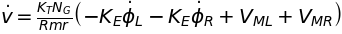

In [3]:
m, v, x, dotv, dotx = symbols('m v x \dot{v} \dot{x}')
FR, FL  = symbols('F_R F_L')
r, Ng = symbols('r N_{G}')
FR = Ng*tau_R/r
FL = Ng*tau_L/r

print('モータトルクとタイヤに働く力の関係式')
display(Eq(symbols('F_R'), FR))
display(Eq(symbols('F_L'), FL))


print("運動方程式")
eq3_v = Eq(dotv, (FR+FL)/m); 
eq3_x = Eq(v, dphiR*r/Ng+dphiL*r/Ng );
# eq3_vx = Eq(dotx, v)

display(simplify(eq3_v), eq3_x)

ここで式を簡単にするために，
$$ \dot{\phi}:= \dot{\phi}_R + \dot{\phi}_L $$
$$ V_m := V_R + V_L$$
と定義する．すると，

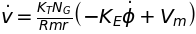

In [4]:
# TODO: 等式に代入することはできる？
phi, dphi, Vm = var('\phi \dot{\phi} V_m')

eq4_x = Eq(dotx, v)
eq4_v = Eq(dotv, (KT*Ng)/(R*m*r)*(-KE*dphi+ Vm))
eq4_phi = Eq(v, dphi*r/Ng)

display(eq4_x,eq4_v, eq4_phi)

という式が得られました．この式を $\dot{x},\dot{v},\dot{phi}$について整理してみます．すると次のような関係式が得られます．

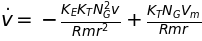

In [5]:
sols = solve([eq4_v, eq4_phi, eq4_x], [dotv, dphi, dotx])

eq_sol_v = Eq(dotv, sols[dotv])
eq_sol_phi = Eq(dphi, sols[dphi])
eq_sol_x = Eq(dotx, sols[dotx])

display(eq_sol_x, expand(eq_sol_v),eq_sol_phi)

この式で一番重要なのは，2番目の式です．  
この式から，DCモーターによって駆動するマイクロマウスの速度-加速度の関係は，一階の線形微分方程式で表現され，
加速度$a=\dot{v}$は現在の速度$v$とモータに入力する電圧$Vm$で決定されることが分かります．
また，速度$v$にかかる係数の符号は負であるため，速度と加速度の間にはトレードオフの関係があることが分かります．

シミュレーションをする上で，上式をそのまま使っても数値計算はできますが，**「状態方程式(StateSpace)」**形式に形を少し変えると，
多入力多出力システムの表現しやすいほか，既存のライブラリで計算がしやすくなりますので少しだけ，式変形をしてみましょう．

状態方程式は，状態変数$X=[x_1, x_2,...,x_n]^T$および出力変数$Y=[y_1, y_2,...,y_m]^T$ に対して($T$は転置記号)，次のような係数行列$A,B,C$を含んだ形式で表される方程式です．(対象によっては，2番目の式を$Y=CX + Du$とする場合もあります)

\begin{eqnarray}
    \dot{X} &=& AX + Bu \\
    Y &=& CX
\end{eqnarray}

今回の直進モデルにおいては，状態変数は$X=[x, v, \phi]^T$ となります．$Y$は実際にセンサーなどによって観測できる変数を指します．  
状態変数Xはロータリエンコーダや加速度センサなどを用いて，（間接的に）計測することが可能なので，  
ここでは簡単のため状態変数は全てそのまま観測可能としてしまいましょう．

よって，$I_3 (\mathbb{R}^{3\times3})$の単位行列を用いて

$$C=I_3 = \left[\begin{matrix}1 & 0 & 0\\0 & 1 & 0\\0 & 0 & 1\end{matrix}\right]
$$

$$Y=I_3X = X$$

となりました．

>#### ※補足
ここでは，簡単のため$C=I_3$と置いてしまいましたが，現実にはセンサの精度やノイズなどにより正確に計測ができない場合もあります．
例えば，速度$v$を求めるならエンコーダの値を微分するのが簡単ですが，ノイズの乗った値を微分すると速度一定にもかかわらず波形がギザギザになってしまうことがあります．（特に磁気式エンコーダ）  
こういった場合，ノイズは高周波成分を多く含むことが多いため，単純に出力値に**ローパスフィルタ**を掛けるか，もしくは
モデルと入出力情報から統計的に状態変数を推定する**「カルマンフィルタ」**などの最尤推定オブザーバで対処することが有効です．

>参考: [状態フィードバックと状態変数観測器](http://www.mech.tohoku-gakuin.ac.jp/rde/contents/course/controlII/statefeedback.html)


In [6]:
polv = Poly(sols[dotv], v)
polvm = Poly(sols[dotv], Vm)
polp = Poly(sols[dphi], v)

a = polv.coeffs()[0] # polvの0番目の係数
b = polvm.coeffs()[0] # polvの1番目の係数
c = polp.coeffs()[0] # polpの0番目の係数

A = Matrix([ [0,1,0], [0,a,0], [0,c,0]])
B = Matrix([0, b, 0])
X = Matrix([x, v, phi])
dX = Matrix([dotx, dotv, dphi])

print('<DCマウスの直進モデル>')
Eq(dX, MatAdd(MatMul(A,X), MatMul(B,Vm)))

<DCマウスの直進モデル>


⎡ \dot{x}  ⎤ = ⎡0         1          0⎤⋅⎡ x  ⎤ + ⎡    0    ⎤⋅Vₘ
⎢          ⎥   ⎢                      ⎥ ⎢    ⎥   ⎢         ⎥   
⎢ \dot{v}  ⎥   ⎢                 2    ⎥ ⎢ v  ⎥   ⎢K_T⋅N_{G}⎥   
⎢          ⎥   ⎢   -K_E⋅K_T⋅N_{G}     ⎥ ⎢    ⎥   ⎢─────────⎥   
⎣\dot{\phi}⎦   ⎢0  ────────────────  0⎥ ⎣\phi⎦   ⎢  R⋅m⋅r  ⎥   
               ⎢             2        ⎥          ⎢         ⎥   
               ⎢        R⋅m⋅r         ⎥          ⎣    0    ⎦   
               ⎢                      ⎥                        
               ⎢        N_{G}         ⎥                        
               ⎢0       ─────        0⎥                        
               ⎣          r           ⎦                        

DCマウスの直進モデルは上記の式で与えられることが分かりました．

ただし，実際のDCモーターを動かす際は，モータードライバにPWM信号を入力することになるので，  
入力はPWMのデューティー比{-1,+1}としたほうが扱いやすいかもしれません．

そこで，電源電圧を$V_{bat}$，2つのモータに対する平均デューティー比を$u_{duty}$とおくと，
モーターへの合計入力電圧$V_m$は

$$ V_m = 2V_{bat}u_{duty} $$

と表すことができます．よってデューティー入力の直進モデルは，次のように表すことができます．
以降はこのモデルを用いて，制御系設計を行っていきます．

In [7]:
print('<DCマウスの直進モデル>')
u_d, Vbat = symbols('u_{duty} V_{bat}')
Eq(dX, MatAdd(MatMul(A,X), MatMul(B*2*Vbat,u_d)))

<DCマウスの直進モデル>


⎡ \dot{x}  ⎤ = ⎡0         1          0⎤⋅⎡ x  ⎤ + ⎡         0         ⎤⋅u_{duty
⎢          ⎥   ⎢                      ⎥ ⎢    ⎥   ⎢                   ⎥        
⎢ \dot{v}  ⎥   ⎢                 2    ⎥ ⎢ v  ⎥   ⎢2⋅K_T⋅N_{G}⋅V_{bat}⎥        
⎢          ⎥   ⎢   -K_E⋅K_T⋅N_{G}     ⎥ ⎢    ⎥   ⎢───────────────────⎥        
⎣\dot{\phi}⎦   ⎢0  ────────────────  0⎥ ⎣\phi⎦   ⎢       R⋅m⋅r       ⎥        
               ⎢             2        ⎥          ⎢                   ⎥        
               ⎢        R⋅m⋅r         ⎥          ⎣         0         ⎦        
               ⎢                      ⎥                                       
               ⎢        N_{G}         ⎥                                       
               ⎢0       ─────        0⎥                                       
               ⎣          r           ⎦                                       

}
 
 
 
 
 
 
 
 
 
 